In [78]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import pandas as pd
import rioxarray as rxr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import polars as pl #libs for faster data processing


from dateutil import tz
import geopandas as gpd

from pyproj import CRS


import sklearn.metrics as metrics
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression


os.chdir('/Users/gaurav/UAH/temperature_modelling/')

#Custom modules
import lib.satellite as sat
import lib.dataprocess as dp 
import lib.crowdqc as cqc
from lib import helper
from lib import modeller as mod
from lib import visualizer



#For the issue with .loc[]
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1 : Clean Data 

Run     : python lib/cleaner.py Madison 2021 <br>
Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

In [3]:
#updating necessary columns from satellite
necessary_col_sat = ['station', 'beg_time', 'latitude', 'longitude', 
                # 'humidityAvg',
                  'temperature',
               # 'windspeed', 'dewpt', 'heatindex', 'precipRate',
               'day_of_year',
               'hour', 'adjusted_lst', 'valueImperviousfraction', 'valueTreefraction',
               'valueBuildingheight', 'valueNearestDistWater', 'valueWaterfraction',
               # 'valueLandcover', 
               'valueBuildingfraction']

#updating temporal columns
spatial_columns = [ 'station', 'beg_time', 'latitude','longitude',
                     'temperature', 
                     'closest_station_1_temp','closest_station_2_temp','closest_station_3_temp',
                     'closest_1_distance','closest_2_distance','closest_3_distance',
                     ]

##### Note : 
# 1. valueLandcover is not included as it is categorical
default_location = 'Madison'
default_year = 2021


In [5]:
#Readin PWS Data
### Step 1 : Clean Data 
#Run     : python lib/cleaner.py Madison 2021 <br>
#Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

clean_data = pd.read_csv('data/processed_data/Madison_2021/clean_Madison_pws_.csv')
# clean_data = pd.read_csv('data/processed_data/Madison_2022/clean_Madison_pws_.csv')
clean_data['beg_time'] = pd.to_datetime(clean_data['beg_time'])
clean_data['hour'] = clean_data['beg_time'].dt.hour

clean_data = clean_data.query("day_of_year >= 30 & day_of_year <= 210")
clean_data.station = clean_data.station.str.upper()

# dp.plot_(clean_data,'day_of_year',200)


### Step 2: Generate Ecostress and Urban Satellite Data

In [544]:
sat.create_station_file('Madison',2021,urban_data=False)
# sat.create_station_file('Madison',2021,urban_data=True)

/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_01.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_16.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_02.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_14.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_00.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_17.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory

### Step 4 : Calculate Adjsuted LST


#### Note : 
By now I have access to : <br>
- One **clean_data** dataframe that records hourly temperature for each station for 1 year.
-  **result_df** dataframe that has adjusted LST temperature (i.e. LST-mean(LST)).
- **urban_data** dataframe that has urban surface properties.
    - The **valueLandcover** column is categorical

In [6]:
# This data consists of stations, lat, long, time, temp adjusted lst and all surface values
#The process raster data function is used to download the satellite data and process it

eco_data = mod.process_raster_data(clean_data,create=False,year=default_year,location=default_location)
eco_data = eco_data[necessary_col_sat]

### Step 5 : EDA of urban surface properties 

### Step 6 : Modelling Data

In [218]:
#This data combines stations with closest stations
temperature_data = helper.find_closest_temperatures(eco_data)


#### Step 6.1 : Strategy for Null Values

1. Filling null closest temperature vallues with interpolation
2. In the future, it can be replaced with second closest or average

#### Step 6.2 : Splitting into sequences


**Model 1 : Linear Regression**

In [256]:
from sklearn.preprocessing import StandardScaler

window_size = 5
#Its here because I don't want to pass final_df everytime
def get_partitions(final_df,col_list,selection_hour,scaler=False):
    ''' Get final split of data based on hour selected
        selection_hour = [1] or None
    '''
    final_df_x = final_df.query(f'hour == {list([selection_hour or list(np.arange(0,24,1))][0])}')
    X_train, X_test, y_train, y_test = mod.get_train_test_data(final_df_x,window_size)
    hour_status = final_df_x.hour.unique()

    d_train, d_test = X_train[col_list], X_test[col_list]

    #if there is no hour column, then its set to none, such that the plotter function behaves accordingly
    # hour_status = True if 'hour' in d_train.columns else False

    if scaler:
        scaler = StandardScaler()

        d_train =  scaler.fit_transform(d_train)
        d_train = pd.DataFrame(d_train,columns=col_list)
        d_test = scaler.transform(d_test)
        d_test = pd.DataFrame(d_test,columns=col_list)

    return [d_train, d_test, y_train, y_test], hour_status


def bulk_model_runner(model,grouped_data,col_list,delete=True,bulk_mode=True,fit = True,residuals=False):
    ''' This function runs the model for all hours and saves the predictions and error
        grouped_data = data grouped by station
        col_list = columns to be used for modelling
        delete = True if you want to delete the contents of directory
        bulk_mode = True if you want to train one model for each hour
        fit = True if you want to fit the model, False if you want to load the model
    '''

    #cleaning the directory first
    model_name = model.__class__.__name__
    model_path = os.path.join(mod.MODEL_PATH,model_name)
    if delete:
        helper.clean_directory(model_path)

    new_grouped_data = grouped_data.copy()

    if residuals:
        #group the grouped data by hour to find hourly mean and subtract it from the temperature
        print('Residuals are being subtracted from data')
        new_grouped_data['delta_temp'] = new_grouped_data['temperature']-new_grouped_data.groupby('hour')['temperature'].transform('mean')
        new_grouped_data['old_temperature'] = new_grouped_data['temperature']
        new_grouped_data['temperature'] = new_grouped_data['delta_temp']
        hour_lookup = new_grouped_data.groupby('hour')['old_temperature'].mean().reset_index()


    model_dict = {}
    model_output_dict = {}
    if bulk_mode:
        feature_importances_dict = dict()
        for hour_ in range(24):
            data,hour_status = get_partitions(new_grouped_data,col_list,[hour_])  #or None
            predictions,error = mod.train_save(model, data, hour_status)
            try:
                feature_importances = model.feature_importances_
            except:
                feature_importances = None
            model_dict[hour_] = [predictions,error,feature_importances]

        for hour in model_dict.keys():
            feature_importances_dict[hour] = model_dict[hour][2]
            model_dict[hour][0]['hourly_rms'] = model_dict[hour][1]

        hour0 = model_dict[0][0]

        for hour in model_dict.keys():
            if hour != 0:
                hour0 = pd.concat([hour0,model_dict[hour][0]],axis=0)

        model_output_dict['hourly_values'] = hour0
        model_output_dict['feature_importances'] = pd.DataFrame(feature_importances_dict).mean(axis=1).values

        
        
    
    if not bulk_mode:
        data,hour_status = get_partitions(new_grouped_data,col_list,None)
        predictions,error = mod.train_save(model, data, hour_status)
        try:
            feature_importances = model.feature_importances_
        except:
            feature_importances = None
        model_dict['hourly_values'] = [predictions,error,feature_importances]

        #new module to uniformly output data
        combined_df = model_dict['hourly_values'][0]
        hourly_rmse = combined_df.groupby('hour').apply(lambda x : metrics.mean_squared_error(x.predicted_temperature,x.true_temperature,squared=False)).reset_index(name='hourly_rms')
        combined_df = pd.merge(combined_df, hourly_rmse, on='hour')

        model_output_dict['hourly_values'] = combined_df
        model_output_dict['feature_importances'] = model_dict['hourly_values'][2]

    if residuals:
        print('Residuals are being added back to the predictions')
        predictions = model_output_dict['hourly_values']

        model_dict_updated = predictions.merge(hour_lookup,on='hour')
        model_dict_updated['predicted_temperature'] = model_dict_updated['predicted_temperature']+model_dict_updated['old_temperature']
        model_dict_updated['true_temperature'] = model_dict_updated['true_temperature']+model_dict_updated['old_temperature']

        model_output_dict['hourly_values'] = model_dict_updated
    
        
    return model_output_dict

In [257]:
temperature_data_segment = temperature_data.query("beg_time >= '2021-06-01' & beg_time < '2021-07-01'")
final_df = mod.get_final_df(temperature_data_segment,eco_data,spatial_columns)
grouped_data = final_df.groupby(['station','hour']).mean().reset_index()

#Data cleaning pipeline 
# cqc.level_1_plot(grouped_data)
flag_stations = cqc.cleaning_outliers(grouped_data)
missing_stations = cqc.clean_missing_data(final_df,print_missing=False)


In [258]:
import plotly.express as pe

grouped_data = grouped_data.query("station not in @flag_stations")
grouped_data = grouped_data.query("station not in @missing_stations")
grouped_data['beg_time'] = final_df['beg_time'][0]

#WIll be used for plotting scatter plots
helper.convert_to_gpd(grouped_data,'epsg:4326',convert_to='epsg:6879')[['hour','latitude','longitude','temperature']].to_csv('Analytics/temp_data/grouped_data.csv',index=False)


# pe.scatter(grouped_data, x="hour", y="temperature", color='station', title='Temperature Pattern for Normal Stations',)

In [76]:
#group the grouped data by hour to find hourly mean and subtract it from the temperature

grouped_data['delta_temp'] = grouped_data['temperature']-grouped_data.groupby('hour')['temperature'].transform('mean')
grouped_data['old_temperature'] = grouped_data['temperature']
grouped_data['temperature'] = grouped_data['delta_temp']

In [734]:
hour_lookup = grouped_data.groupby('hour')['old_temperature'].mean().reset_index()
predictions = model_dict[25][0]

model_dict_updated = predictions.merge(hour_lookup,on='hour')
model_dict_updated['predicted_temperature'] = model_dict_updated['predicted_temperature']+model_dict_updated['old_temperature']
model_dict_updated['true_temperature'] = model_dict_updated['true_temperature']+model_dict_updated['old_temperature']

model_dict[25][0] = model_dict_updated



Residuals are being subtracted from data
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_0.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_1.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_2.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_3.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_4.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_5.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/RandomForestRegressor/RandomForestRegressor_6.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Re

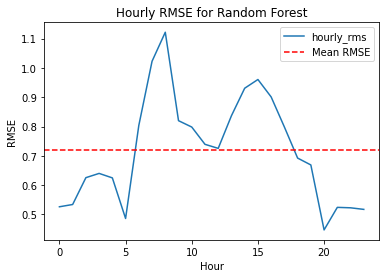

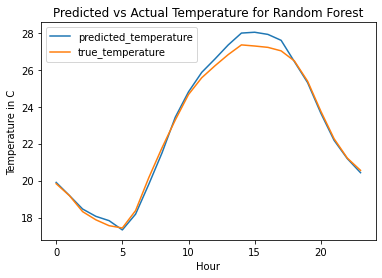

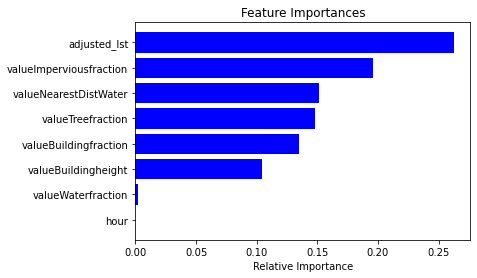

In [237]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                            n_estimators=300)


# model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=False,delete=True)
# visualizer.plot_mean(model_dict,'Random Forest',col_list)

model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=True,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'Random Forest',col_list)


Text(0.5, 1.0, 'Mean and Standard Deviation of Predicted and Actual Temperature :Random Forest')

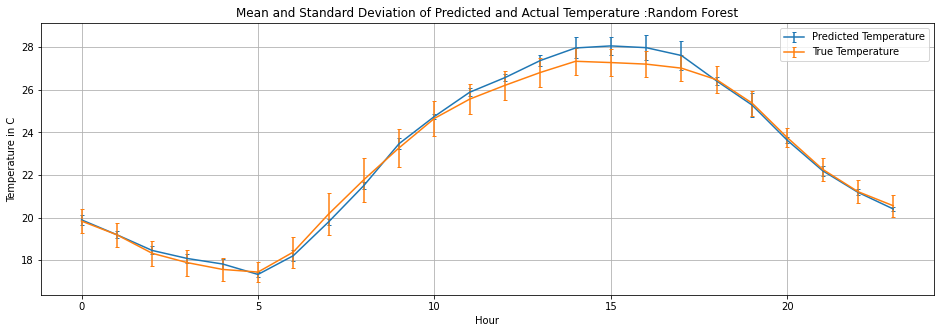

In [294]:
mean_std_matrix = model_dict['hourly_values'].groupby('hour')[['predicted_temperature','true_temperature']].agg(['std','mean']).reset_index()
plt.figure(figsize=(16,5))
plt.errorbar(mean_std_matrix['hour'],mean_std_matrix['predicted_temperature']['mean'],mean_std_matrix['predicted_temperature']['std'],label = 'Predicted Temperature', capsize=2, capthick=1)
plt.errorbar(mean_std_matrix['hour'],mean_std_matrix['true_temperature']['mean'],mean_std_matrix['true_temperature']['std'],label = 'True Temperature', capsize=2, capthick=1)

plt.xlabel('Hour')
plt.ylabel('Temperature in C')
plt.legend()
plt.grid()
plt.title('Mean and Standard Deviation of Predicted and Actual Temperature :Random Forest')



## Using 2021 model on 2022 data

In [503]:
def plot_mean(model, x_test, y_test, hour_filter):

    plot_df = x_test.copy()
    plot_df['predicted_temperature'] = model.predict(plot_df)
    plot_df['true_temperature'] = y_test
    plot_df['hour'] = hour_filter
    error_score = metrics.mean_squared_error(plot_df['true_temperature'],plot_df['predicted_temperature'],squared=False,)

    return plot_df,error_score

model_name = 'GradientBoostingRegressor'
model_dict_new = {}
for hour_ in range(24):
    data,hour_status = get_partitions(grouped_data,col_list,[hour_])  #or None
    model_path = os.path.join(mod.MODEL_PATH,str(model_name),model_name+f'_{hour_}.sav')
    model = pickle.load(open(model_path, 'rb'))
    predictions,error = plot_mean(model, data[1],data[3], hour_)
    model_dict_new[hour_] = [predictions,error,None]




Feature importances not available


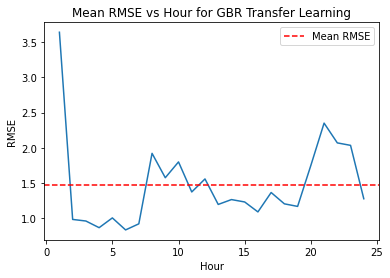

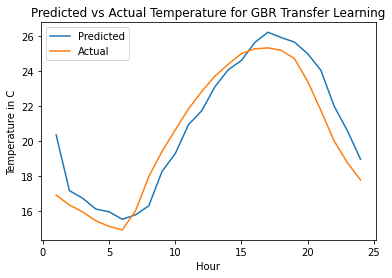

In [505]:
visualizer.plot_mean(model_dict_new,'GBR Transfer Learning',col_list)

**Model 2 : XGBoost**

In [315]:
new_grouped_data = grouped_data.copy()

new_grouped_data['delta_temp'] = new_grouped_data['temperature']-new_grouped_data.groupby('hour')['temperature'].transform('mean')
new_grouped_data['old_temperature'] = new_grouped_data['temperature']
new_grouped_data['temperature'] = new_grouped_data['delta_temp']
hour_lookup = new_grouped_data.groupby('hour')['old_temperature'].mean().reset_index()


In [318]:
hour_lookup['old_temperature'].to_dict()

{0: 20.132882848553226,
 1: 19.515604300601513,
 2: 18.788010171475747,
 3: 18.298537757274303,
 4: 17.993850203090147,
 5: 17.78381505279561,
 6: 18.352803663662996,
 7: 19.896791236267397,
 8: 21.55406047687993,
 9: 23.23506753977323,
 10: 24.74204487965444,
 11: 25.754689877395325,
 12: 26.45128980594597,
 13: 27.16446031410424,
 14: 27.604828246876984,
 15: 27.542281397967802,
 16: 27.389182444883485,
 17: 27.060011989530675,
 18: 26.41412627341282,
 19: 25.34848565761927,
 20: 23.75845859185396,
 21: 22.306288653287663,
 22: 21.39907038338523,
 23: 20.78466924005314}

Residuals are being subtracted from data
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/GradientBoostingRegressor/GradientBoostingRegressor_0.sav
Residuals are being added back to the predictions


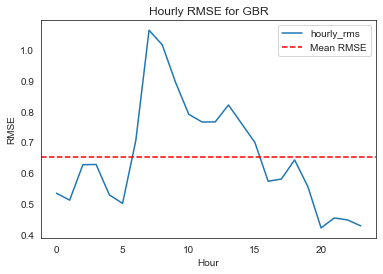

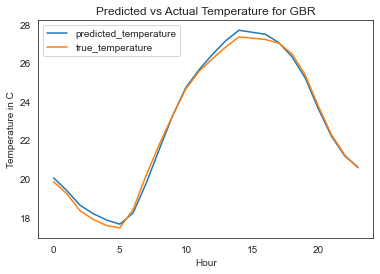

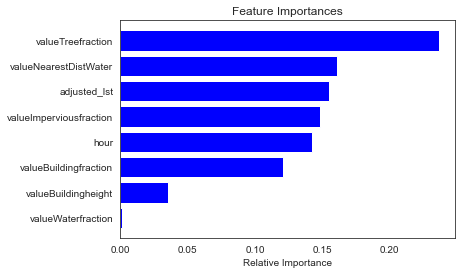

In [314]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            'hour',  
          #   'closest_station_1_temp','closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

gbr = GBR()

model_dict = bulk_model_runner(gbr,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'GBR',col_list)


In [319]:
dp.plot_(grouped_data, animation_frame_comp='hour',resample=False)


Residuals are being subtracted from data
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_0.sav
Residuals are being added back to the predictions


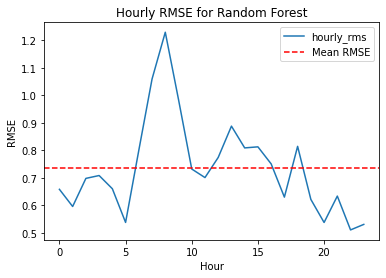

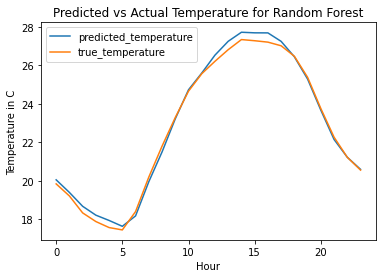

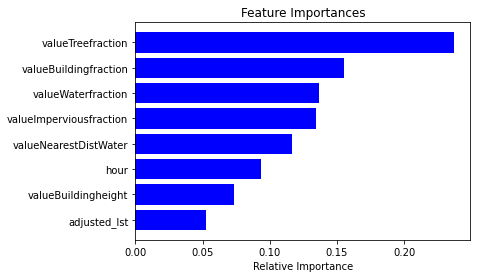

In [304]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 20),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 500)
}


col_list = [
    # 'latitude', 'longitude', 
            'hour', 
          #   'closest_station_1_temp','closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']


xgb_model = xgb.XGBRegressor()

model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'Random Forest',col_list)


Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_0.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_1.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_2.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_3.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_4.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_5.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_6.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_7.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_8.sav
M

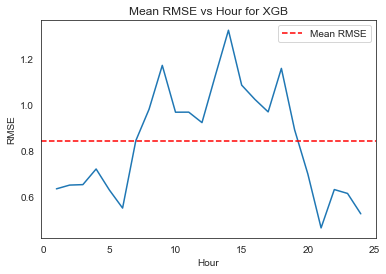

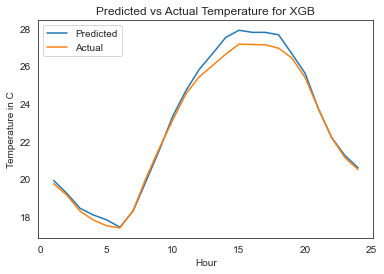

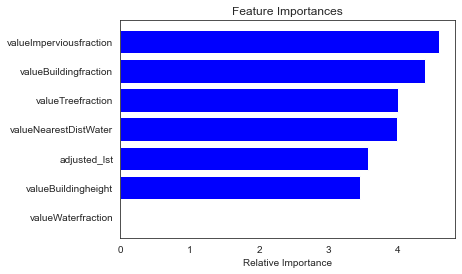

In [646]:

xgb_model = xgb.XGBRegressor(**random_search.best_params_)

col_list = [
    # 'latitude', 'longitude', 
        #     'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=True,delete=True)
visualizer.plot_mean(model_dict,'XGB',col_list)




### Neural Networks

Residuals are being subtracted from data
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/MLPRegressor/MLPRegressor_0.sav
Residuals are being added back to the predictions
Feature importances not available


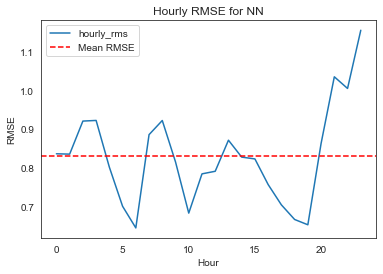

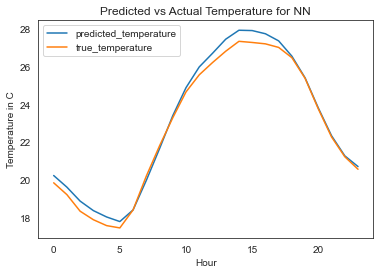

In [313]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']



nn = MLPRegressor(hidden_layer_sizes=(15,10,5),activation='relu', solver='adam', max_iter=500)

model_dict = bulk_model_runner(nn,grouped_data,col_list,bulk_mode=False,delete=True,residuals=True)
visualizer.plot_mean(model_dict,'NN',col_list)


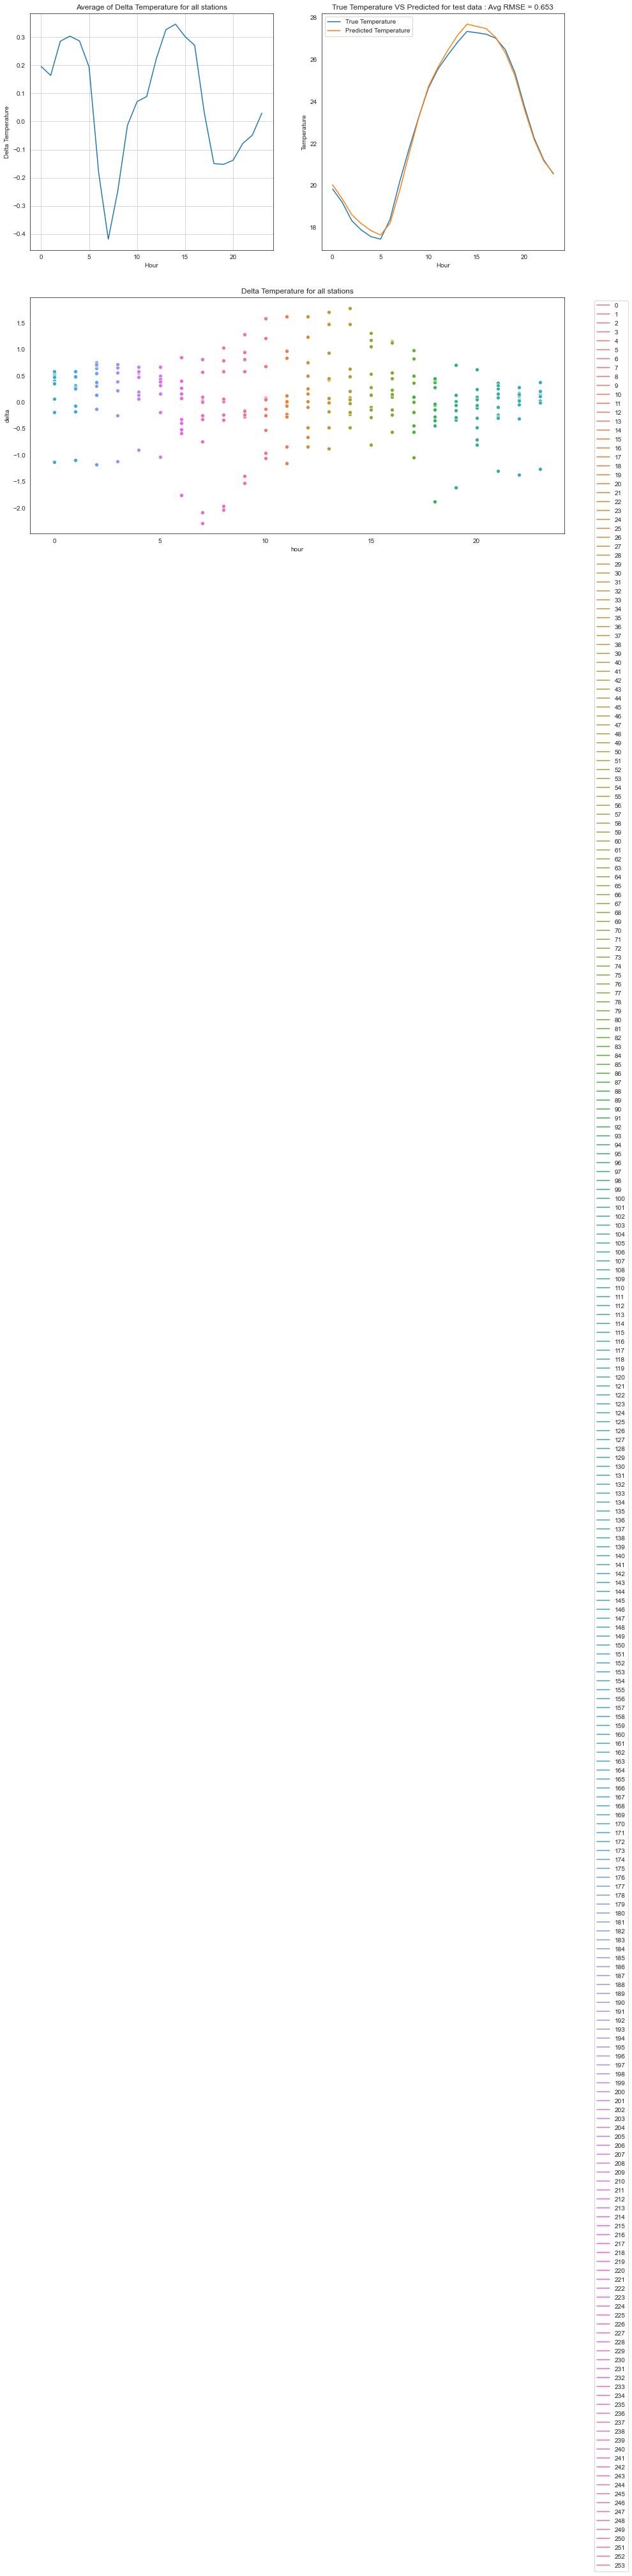

In [320]:
def get_delta_plots(final_dict):
    ''' Final dict is of format : 
        { {hour : [predictions,error,feature_importances]}}
        access : final_dict[0][0],final_dict[5][0]
    '''
    df_ = final_dict['hourly_values']
    df_ = df_[['predicted_temperature','true_temperature','hour','hourly_rms']]
    # df_['hour']  = 0

    # for hrs in final_dict.keys():
    #     if hrs ==0:
    #         continue
    #     datax = final_dict[hrs][0]
    #     datax = datax[['predicted_temperature','true_temperature','hour']]
    #     datax['hour']  = hrs

    #     df_ = pd.concat([df_,datax])

    df_agg = df_.groupby('hour').mean().reset_index()
    df_agg['delta_temp'] = df_agg.predicted_temperature - df_agg.true_temperature


    avg_rmse = df_.hourly_rms.mean()

    df_['station'] = df_.index
    df_['delta'] = df_.predicted_temperature - df_.true_temperature
    df_ = df_.reset_index().drop('index',axis=1)


    import seaborn as sns
    # sns.set_theme(style="whitegrid")
    sns.set_style("white")
    plt.figure(figsize=(15,15))

    plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    sns.lineplot(x=df_agg.hour,y=df_agg.delta_temp)
    plt.title('Average of Delta Temperature for all stations')
    plt.xlabel('Hour')
    plt.grid()

    plt.ylabel('Delta Temperature')


    plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    sns.lineplot(x = df_agg.hour,y = df_agg.true_temperature,label='True Temperature')
    sns.lineplot(x = df_agg.hour,y = df_agg.predicted_temperature,label='Predicted Temperature')
    plt.title(f'True Temperature VS Predicted for test data : Avg RMSE = {round(avg_rmse,3)}')
    plt.xlabel('Hour')
    plt.ylabel('Temperature')

    # Create a subplot that spans the entire second row
    plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=2)
    df_['station'] = df_['station'].astype(str)
    sns.lineplot(x='hour', y='delta', hue='station', data=df_, marker='o')
    plt.title('Delta Temperature for all stations')
    # Show the plot)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



    # plt.tight_layout()
    plt.show()

get_delta_plots(model_dict)